In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import cv2

In [2]:
import typing as t
import os

In [3]:
import pandas as pd
import torch.nn as nn
from tqdm import tqdm

# Лабораторная работа №7: Pix2Pix (вариант №7)

## 1. Загрузка данных

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

### 1.1 Подготовка класса Dataset

In [5]:
def get_train_directory_list(base_train_path: str) -> list[str]:
    train_image_paths = os.listdir(base_train_path)
    return [
        '/'.join((base_train_path, train_image_path)) for train_image_path in train_image_paths
    ]


In [6]:
class Pix2PixDataset(Dataset):
    def __init__(self, train_directory_list: list[str], reverse=False):
        self.train_directory_list = train_directory_list
        self.reverse = reverse
        
    def __len__(self):
        return len(self.train_directory_list)
    
    def __getitem__(self, idx):
        image_path = self.train_directory_list[idx]
        
        image = read_image(image_path).to(torch.float32)
        
        n = image.size()[2] // 2
        
        x = image[:, :, :n] / 255.
        y = image[:, :, n:] / 255.
        
        if self.reverse:
            return y, x

        return x, y

### 1.2 Загрузка данных

In [7]:
def draw_train(dataset: Dataset) -> None:
    x, y = dataset[0]
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 8))
    
    ax[0].set_title('Исходное изображение')
    ax[0].imshow(x.numpy().transpose(1, 2, 0))
    
    ax[1].set_title('Результирующее изображение')
    ax[1].imshow(y.numpy().transpose(1, 2, 0))

In [8]:
batch_size = 8

#### 1.2.1 City scapes

In [9]:
train_path = '/kaggle/input/pix2pix-dataset/cityscapes/cityscapes/train'

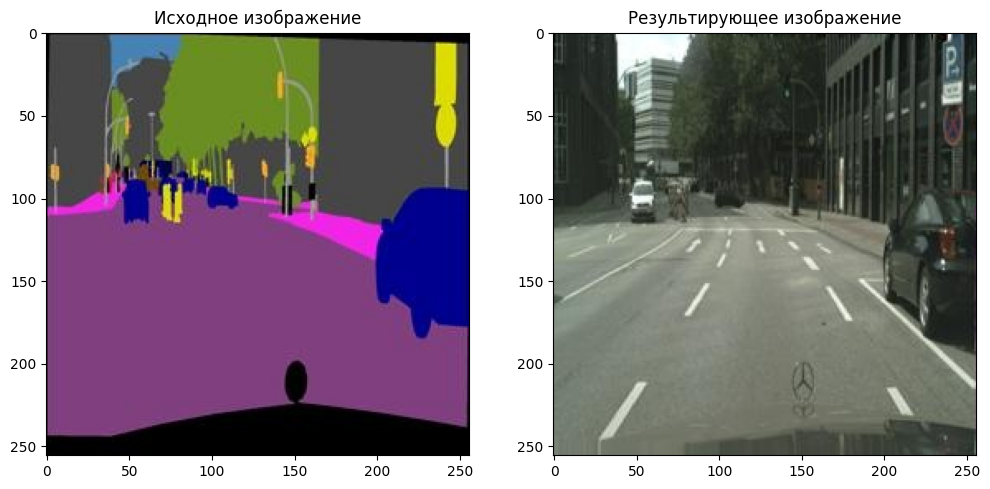

In [10]:
city_scapes_dataset = Pix2PixDataset(get_train_directory_list(train_path), reverse=True)
draw_train(city_scapes_dataset)

In [11]:
city_scapes_dataloader = DataLoader(city_scapes_dataset, batch_size=batch_size)

#### 1.2.2 Facades

In [61]:
train_path = '/kaggle/input/pix2pix-dataset/facades/facades/train'

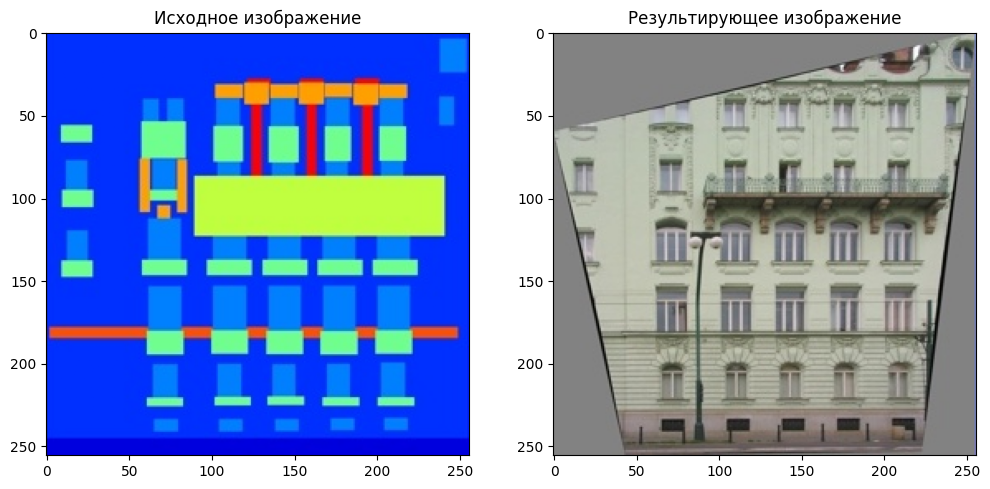

In [62]:
facades_dataset = Pix2PixDataset(get_train_directory_list(train_path), reverse=True)
draw_train(facades_dataset)

In [63]:
facades_dataloader = DataLoader(facades_dataset, batch_size=batch_size)

#### 1.2.3 Maps

In [18]:
train_path = '/kaggle/input/pix2pix-dataset/maps/maps/train'

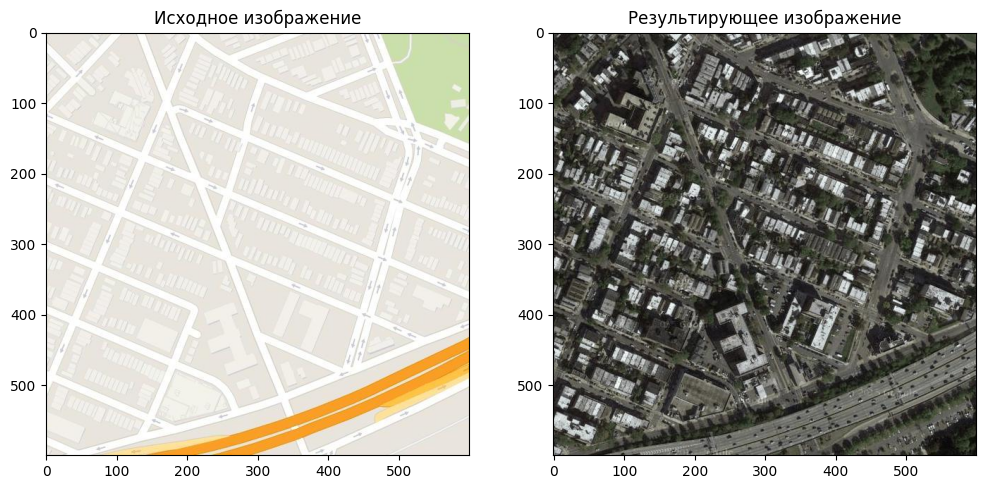

In [19]:
maps_dataset = Pix2PixDataset(get_train_directory_list(train_path), reverse=True)
draw_train(maps_dataset)

In [20]:
maps_dataloader = DataLoader(maps_dataset, batch_size=batch_size)

## 2 Подготовка моделей

В качестве модели генератора будет использоваться UNet, на выходе которого будет 3 карты признаков с исходными размерами (длины и ширины + 3 канала).

In [21]:
class Discriminator(nn.Module):
    def __init__(self, in_channels) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 5, 2, 1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, 5, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 256, 5, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 512, 5, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(512, 1, 1, 2, 1),
            nn.BatchNorm2d(1),
            nn.LeakyReLU(0.2),
        )
        
    def forward(self, x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
        return self.model(torch.cat([x1, x2], axis=1))

## 3. Обучение модели и получение предсказаний

In [22]:
!pip install segmentation_models_pytorch -qqq

In [23]:
import segmentation_models_pytorch as smp

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [52]:
def get_predict(model: nn.Module, val_base_path: str, n: int = 0, reverse=False) -> None:
    val_image_path = get_train_directory_list(val_base_path)[n]
    
    image = read_image(val_image_path).to(torch.float32)

    split = image.size()[2] // 2
    
    x = image[:, :, :split] / 255.
    y = image[:, :, split:] / 255.
    
    if reverse:
        x = image[:, :, split:] / 255.
        y = image[:, :, :split] / 255.

    predict = model(x.unsqueeze(0))[0]
    
    fig, ax = plt.subplots(1, 3, figsize=(18, 9))
    
    ax[0].set_title('Исходное изображение')
    ax[0].imshow(x.numpy().transpose(1, 2, 0))
    
    ax[1].set_title('Реальный результат')
    ax[1].imshow(y.numpy().transpose(1, 2, 0))
    
    ax[2].set_title('Предсказание')
    ax[2].imshow(predict.cpu().detach().numpy().transpose(1, 2, 0))

### 3.1 City scapes

In [34]:
torch.cuda.empty_cache()

In [35]:
G = smp.Unet(classes=3)
D = Discriminator(6)

In [36]:
G = nn.DataParallel(G).to(device)
D = nn.DataParallel(D).to(device)

In [37]:
bce_criterion = nn.BCEWithLogitsLoss()
l1_criterion = nn.L1Loss()

optimizer = torch.optim.Adam(list(G.parameters()) + list(D.parameters()), lr=1e-4)

In [ ]:
epoch_number = 30

In [38]:
fit_history = []

G.train()
D.train()

for epoch in tqdm(range(epoch_number)):
    loss_values = []
    for x_batch, y_batch in city_scapes_dataloader:

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        fake = G(x_batch)
        fake_logits = D(fake, x_batch)
        real_logits = D(y_batch, x_batch)

        bce_loss = bce_criterion(fake_logits, torch.ones_like(fake_logits))
        l1_loss = l1_criterion(fake, y_batch)

        G_loss = bce_loss + 200 * l1_loss

        fake_loss = bce_criterion(fake_logits, torch.zeros_like(fake_logits))
        real_loss = bce_criterion(real_logits, torch.ones_like(real_logits))

        disc_loss = (real_loss + fake_loss) / 2

        loss = G_loss + disc_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        x_batch = x_batch.to('cpu')
        y_batch = y_batch.to('cpu')

        del x_batch
        del y_batch

        loss_values.append(loss.item())

    mean_loss = np.mean(loss_values)
    fit_history.append(mean_loss)
    print(f'Эпоха {epoch + 1}, среднее значение функции потерь: {mean_loss}\n')

  3%|▎         | 1/30 [01:27<42:27, 87.83s/it]

Эпоха 1, среднее значение функции потерь: 34.98236493654149



  7%|▋         | 2/30 [02:55<40:57, 87.78s/it]

Эпоха 2, среднее значение функции потерь: 20.784003944807154



 10%|█         | 3/30 [04:23<39:26, 87.63s/it]

Эпоха 3, среднее значение функции потерь: 20.143348399028984



 13%|█▎        | 4/30 [05:51<38:02, 87.80s/it]

Эпоха 4, среднее значение функции потерь: 19.609755949307512



 17%|█▋        | 5/30 [07:18<36:35, 87.81s/it]

Эпоха 5, среднее значение функции потерь: 19.27268370248938



 20%|██        | 6/30 [08:46<35:06, 87.76s/it]

Эпоха 6, среднее значение функции потерь: 18.649871785153625



 23%|██▎       | 7/30 [10:14<33:43, 87.98s/it]

Эпоха 7, среднее значение функции потерь: 17.976336045931745



 27%|██▋       | 8/30 [11:43<32:17, 88.06s/it]

Эпоха 8, среднее значение функции потерь: 17.48474443599742



 30%|███       | 9/30 [13:11<30:51, 88.18s/it]

Эпоха 9, среднее значение функции потерь: 16.91259011658289



 33%|███▎      | 10/30 [14:40<29:28, 88.41s/it]

Эпоха 10, среднее значение функции потерь: 16.538879984168595



 37%|███▋      | 11/30 [16:09<28:01, 88.48s/it]

Эпоха 11, среднее значение функции потерь: 16.16917872428894



 40%|████      | 12/30 [17:38<26:35, 88.63s/it]

Эпоха 12, среднее значение функции потерь: 15.811565053078436



 43%|████▎     | 13/30 [19:08<25:15, 89.14s/it]

Эпоха 13, среднее значение функции потерь: 15.647609477402062



 47%|████▋     | 14/30 [20:37<23:43, 89.00s/it]

Эпоха 14, среднее значение функции потерь: 15.466486161754977



 50%|█████     | 15/30 [22:07<22:19, 89.28s/it]

Эпоха 15, среднее значение функции потерь: 15.21155849836206



 53%|█████▎    | 16/30 [23:35<20:47, 89.08s/it]

Эпоха 16, среднее значение функции потерь: 14.967447796175557



 57%|█████▋    | 17/30 [25:04<19:15, 88.89s/it]

Эпоха 17, среднее значение функции потерь: 14.651930534711449



 60%|██████    | 18/30 [26:32<17:45, 88.80s/it]

Эпоха 18, среднее значение функции потерь: 14.454965840103807



 63%|██████▎   | 19/30 [28:00<16:14, 88.60s/it]

Эпоха 19, среднее значение функции потерь: 14.332460864897698



 67%|██████▋   | 20/30 [29:29<14:45, 88.58s/it]

Эпоха 20, среднее значение функции потерь: 14.178272847206362



 70%|███████   | 21/30 [30:57<13:15, 88.41s/it]

Эпоха 21, среднее значение функции потерь: 13.959415925446377



 73%|███████▎  | 22/30 [32:25<11:47, 88.41s/it]

Эпоха 22, среднее значение функции потерь: 13.745686666939848



 77%|███████▋  | 23/30 [33:54<10:19, 88.50s/it]

Эпоха 23, среднее значение функции потерь: 13.526471786601569



 80%|████████  | 24/30 [35:24<08:52, 88.79s/it]

Эпоха 24, среднее значение функции потерь: 13.432135692206762



 83%|████████▎ | 25/30 [36:52<07:23, 88.73s/it]

Эпоха 25, среднее значение функции потерь: 13.50341792516811



 87%|████████▋ | 26/30 [38:20<05:53, 88.41s/it]

Эпоха 26, среднее значение функции потерь: 13.365959864790721



 90%|█████████ | 27/30 [39:48<04:24, 88.21s/it]

Эпоха 27, среднее значение функции потерь: 13.03532277384112



 93%|█████████▎| 28/30 [41:15<02:56, 88.00s/it]

Эпоха 28, среднее значение функции потерь: 12.864489140049104



 97%|█████████▋| 29/30 [42:43<01:28, 88.11s/it]

Эпоха 29, среднее значение функции потерь: 12.70594669413823



100%|██████████| 30/30 [44:11<00:00, 88.38s/it]

Эпоха 30, среднее значение функции потерь: 12.635121894139116



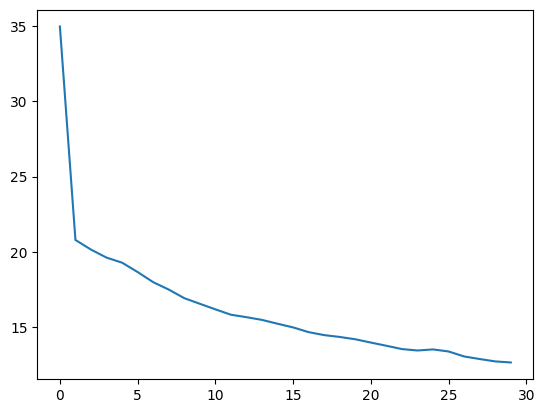

In [39]:
plt.plot(fit_history)

Тут косяк в функции, реальный результат и исходное изображение нужно местами поменять...

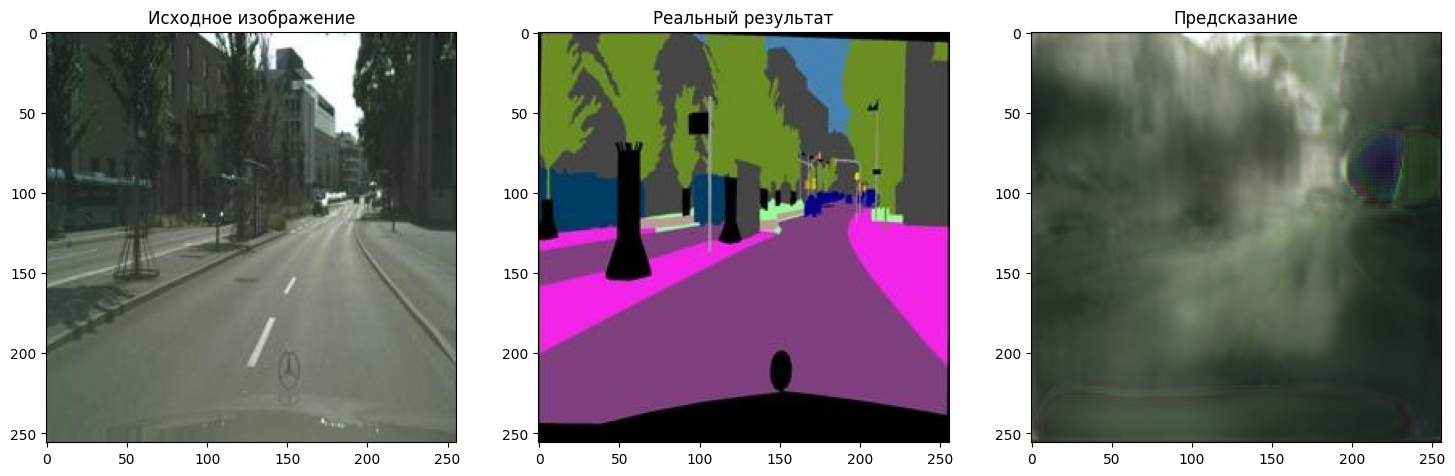

In [44]:
get_predict(G, '/kaggle/input/pix2pix-dataset/cityscapes/cityscapes/val', 0)

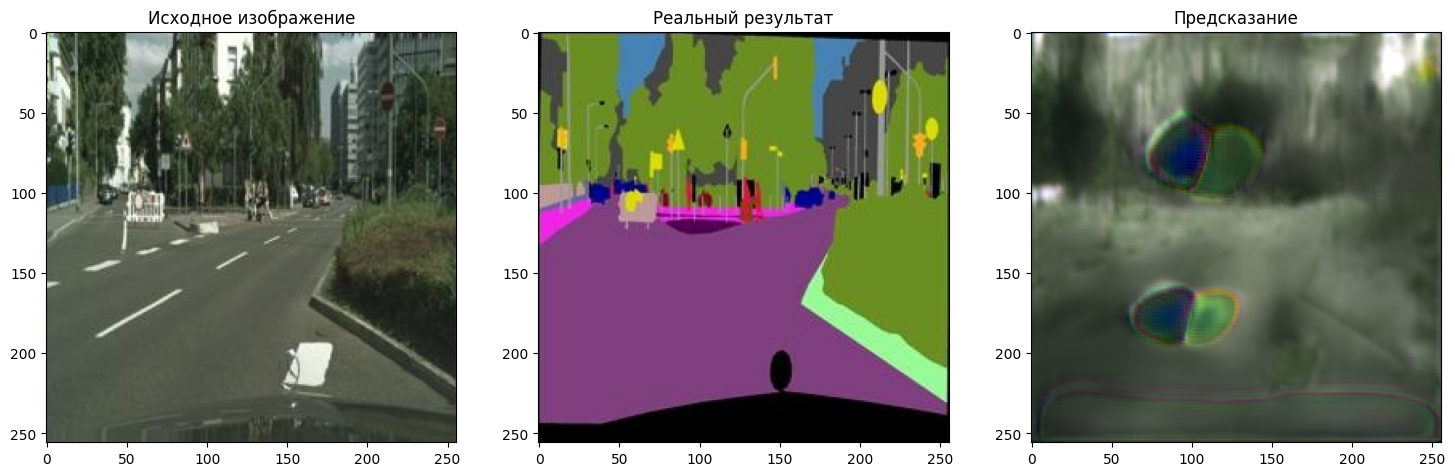

In [46]:
get_predict(G, '/kaggle/input/pix2pix-dataset/cityscapes/cityscapes/val', 10)

### 3.2 Facades

In [69]:
torch.cuda.empty_cache()

In [70]:
G = smp.Unet(classes=3)
D = Discriminator(6)

In [71]:
G = nn.DataParallel(G).to(device)
D = nn.DataParallel(D).to(device)

In [72]:
bce_criterion = nn.BCEWithLogitsLoss()
l1_criterion = nn.L1Loss()

optimizer = torch.optim.Adam(list(G.parameters()) + list(D.parameters()), lr=1e-4)

In [73]:
epoch_number = 150

In [75]:
fit_history = []

G.train()
D.train()

for epoch in tqdm(range(epoch_number)):
    loss_values = []
    for x_batch, y_batch in facades_dataloader:

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        fake = G(x_batch)
        fake_logits = D(fake, x_batch)
        real_logits = D(y_batch, x_batch)

        bce_loss = bce_criterion(fake_logits, torch.ones_like(fake_logits))
        l1_loss = l1_criterion(fake, y_batch)

        G_loss = bce_loss + 200 * l1_loss

        fake_loss = bce_criterion(fake_logits, torch.zeros_like(fake_logits))
        real_loss = bce_criterion(real_logits, torch.ones_like(real_logits))

        disc_loss = (real_loss + fake_loss) / 2

        loss = G_loss + disc_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_values.append(loss.item())

    mean_loss = np.mean(loss_values)
    fit_history.append(mean_loss)
    print(f'Эпоха {epoch + 1}, среднее значение функции потерь: {mean_loss}\n')

  1%|          | 1/150 [00:12<30:02, 12.10s/it]

Эпоха 1, среднее значение функции потерь: 16.78876365661621



  1%|▏         | 2/150 [00:23<29:30, 11.96s/it]

Эпоха 2, среднее значение функции потерь: 16.495664043426515



  2%|▏         | 3/150 [00:35<28:58, 11.83s/it]

Эпоха 3, среднее значение функции потерь: 16.21697151184082



  3%|▎         | 4/150 [00:47<28:49, 11.85s/it]

Эпоха 4, среднее значение функции потерь: 16.184681205749513



  3%|▎         | 5/150 [00:59<28:24, 11.76s/it]

Эпоха 5, среднее значение функции потерь: 16.30994203567505



  4%|▍         | 6/150 [01:10<28:00, 11.67s/it]

Эпоха 6, среднее значение функции потерь: 16.35510896682739



  5%|▍         | 7/150 [01:22<27:52, 11.70s/it]

Эпоха 7, среднее значение функции потерь: 16.2593603515625



  5%|▌         | 8/150 [01:33<27:34, 11.65s/it]

Эпоха 8, среднее значение функции потерь: 16.107026557922364



  6%|▌         | 9/150 [01:45<27:41, 11.79s/it]

Эпоха 9, среднее значение функции потерь: 15.946811561584473



  7%|▋         | 10/150 [01:57<27:32, 11.80s/it]

Эпоха 10, среднее значение функции потерь: 15.710867233276367



  7%|▋         | 11/150 [02:09<27:12, 11.74s/it]

Эпоха 11, среднее значение функции потерь: 15.582857074737548



  8%|▊         | 12/150 [02:21<26:59, 11.74s/it]

Эпоха 12, среднее значение функции потерь: 15.581116161346436



  9%|▊         | 13/150 [02:32<26:43, 11.71s/it]

Эпоха 13, среднее значение функции потерь: 15.463976268768311



  9%|▉         | 14/150 [02:44<26:26, 11.67s/it]

Эпоха 14, среднее значение функции потерь: 15.616808204650878



 10%|█         | 15/150 [02:56<26:32, 11.80s/it]

Эпоха 15, среднее значение функции потерь: 15.68342845916748



 11%|█         | 16/150 [03:08<26:13, 11.74s/it]

Эпоха 16, среднее значение функции потерь: 15.691719799041747



 11%|█▏        | 17/150 [03:19<25:56, 11.71s/it]

Эпоха 17, среднее значение функции потерь: 15.612546463012695



 12%|█▏        | 18/150 [03:31<25:45, 11.71s/it]

Эпоха 18, среднее значение функции потерь: 15.561561660766602



 13%|█▎        | 19/150 [03:43<25:42, 11.77s/it]

Эпоха 19, среднее значение функции потерь: 15.45561824798584



 13%|█▎        | 20/150 [03:55<25:33, 11.80s/it]

Эпоха 20, среднее значение функции потерь: 15.584123973846436



 14%|█▍        | 21/150 [04:06<25:13, 11.73s/it]

Эпоха 21, среднее значение функции потерь: 15.474050006866456



 15%|█▍        | 22/150 [04:18<24:57, 11.70s/it]

Эпоха 22, среднее значение функции потерь: 15.372226085662842



 15%|█▌        | 23/150 [04:30<24:51, 11.75s/it]

Эпоха 23, среднее значение функции потерь: 15.489747047424316



 16%|█▌        | 24/150 [04:41<24:38, 11.73s/it]

Эпоха 24, среднее значение функции потерь: 15.626929759979248



 17%|█▋        | 25/150 [04:53<24:24, 11.71s/it]

Эпоха 25, среднее значение функции потерь: 15.831071491241454



 17%|█▋        | 26/150 [05:05<24:15, 11.74s/it]

Эпоха 26, среднее значение функции потерь: 15.923981742858887



 18%|█▊        | 27/150 [05:17<23:58, 11.70s/it]

Эпоха 27, среднее значение функции потерь: 15.799673118591308



 19%|█▊        | 28/150 [05:28<23:51, 11.74s/it]

Эпоха 28, среднее значение функции потерь: 15.746729145050049



 19%|█▉        | 29/150 [05:40<23:33, 11.68s/it]

Эпоха 29, среднее значение функции потерь: 15.553559894561767



 20%|██        | 30/150 [05:51<23:17, 11.65s/it]

Эпоха 30, среднее значение функции потерь: 15.386947402954101



 21%|██        | 31/150 [06:03<23:09, 11.68s/it]

Эпоха 31, среднее значение функции потерь: 15.261333198547364



 21%|██▏       | 32/150 [06:15<22:51, 11.63s/it]

Эпоха 32, среднее значение функции потерь: 15.2577809715271



 22%|██▏       | 33/150 [06:26<22:36, 11.59s/it]

Эпоха 33, среднее значение функции потерь: 15.082889041900636



 23%|██▎       | 34/150 [06:38<22:31, 11.65s/it]

Эпоха 34, среднее значение функции потерь: 15.072590656280518



 23%|██▎       | 35/150 [06:50<22:14, 11.61s/it]

Эпоха 35, среднее значение функции потерь: 14.905245056152344



 24%|██▍       | 36/150 [07:01<22:13, 11.69s/it]

Эпоха 36, среднее значение функции потерь: 14.666506786346435



 25%|██▍       | 37/150 [07:13<21:58, 11.67s/it]

Эпоха 37, среднее значение функции потерь: 14.504293575286866



 25%|██▌       | 38/150 [07:25<21:40, 11.61s/it]

Эпоха 38, среднее значение функции потерь: 14.560659046173095



 26%|██▌       | 39/150 [07:36<21:32, 11.65s/it]

Эпоха 39, среднее значение функции потерь: 14.586317710876465



 27%|██▋       | 40/150 [07:48<21:17, 11.61s/it]

Эпоха 40, среднее значение функции потерь: 14.540318660736084



 27%|██▋       | 41/150 [07:59<21:01, 11.58s/it]

Эпоха 41, среднее значение функции потерь: 14.488509311676026



 28%|██▊       | 42/150 [08:11<20:54, 11.61s/it]

Эпоха 42, среднее значение функции потерь: 14.480946559906005



 29%|██▊       | 43/150 [08:22<20:38, 11.57s/it]

Эпоха 43, среднее значение функции потерь: 14.409068412780762



 29%|██▉       | 44/150 [08:34<20:36, 11.67s/it]

Эпоха 44, среднее значение функции потерь: 14.154209423065186



 30%|███       | 45/150 [08:46<20:28, 11.70s/it]

Эпоха 45, среднее значение функции потерь: 14.152682132720948



 31%|███       | 46/150 [08:58<20:09, 11.63s/it]

Эпоха 46, среднее значение функции потерь: 14.294047317504884



 31%|███▏      | 47/150 [09:09<19:57, 11.63s/it]

Эпоха 47, среднее значение функции потерь: 14.319825096130371



 32%|███▏      | 48/150 [09:21<19:41, 11.58s/it]

Эпоха 48, среднее значение функции потерь: 14.436666297912598



 33%|███▎      | 49/150 [09:32<19:28, 11.57s/it]

Эпоха 49, среднее значение функции потерь: 14.603521900177002



 33%|███▎      | 50/150 [09:44<19:33, 11.73s/it]

Эпоха 50, среднее значение функции потерь: 14.528787612915039



 34%|███▍      | 51/150 [09:56<19:12, 11.64s/it]

Эпоха 51, среднее значение функции потерь: 14.589379215240479



 35%|███▍      | 52/150 [10:07<18:56, 11.59s/it]

Эпоха 52, среднее значение функции потерь: 14.643826332092285



 35%|███▌      | 53/150 [10:19<18:46, 11.62s/it]

Эпоха 53, среднее значение функции потерь: 14.694616260528564



 36%|███▌      | 54/150 [10:31<18:38, 11.66s/it]

Эпоха 54, среднее значение функции потерь: 14.500307426452636



 37%|███▋      | 55/150 [10:42<18:29, 11.67s/it]

Эпоха 55, среднее значение функции потерь: 14.319782867431641



 37%|███▋      | 56/150 [10:54<18:13, 11.63s/it]

Эпоха 56, среднее значение функции потерь: 14.093402881622314



 38%|███▊      | 57/150 [11:05<17:57, 11.58s/it]

Эпоха 57, среднее значение функции потерь: 13.909870357513428



 39%|███▊      | 58/150 [11:17<17:48, 11.61s/it]

Эпоха 58, среднее значение функции потерь: 13.818713455200195



 39%|███▉      | 59/150 [11:29<17:32, 11.56s/it]

Эпоха 59, среднее значение функции потерь: 13.71152105331421



 40%|████      | 60/150 [11:40<17:19, 11.54s/it]

Эпоха 60, среднее значение функции потерь: 13.67517255783081



 41%|████      | 61/150 [11:52<17:10, 11.57s/it]

Эпоха 61, среднее значение функции потерь: 13.737247276306153



 41%|████▏     | 62/150 [12:03<16:55, 11.54s/it]

Эпоха 62, среднее значение функции потерь: 13.79607192993164



 42%|████▏     | 63/150 [12:15<16:44, 11.55s/it]

Эпоха 63, среднее значение функции потерь: 13.884403953552246



 43%|████▎     | 64/150 [12:26<16:33, 11.56s/it]

Эпоха 64, среднее значение функции потерь: 14.030031051635742



 43%|████▎     | 65/150 [12:38<16:21, 11.55s/it]

Эпоха 65, среднее значение функции потерь: 13.92878999710083



 44%|████▍     | 66/150 [12:49<16:13, 11.59s/it]

Эпоха 66, среднее значение функции потерь: 13.83359941482544



 45%|████▍     | 67/150 [13:01<15:58, 11.55s/it]

Эпоха 67, среднее значение функции потерь: 13.69282663345337



 45%|████▌     | 68/150 [13:12<15:44, 11.52s/it]

Эпоха 68, среднее значение функции потерь: 13.832936592102051



 46%|████▌     | 69/150 [13:24<15:38, 11.59s/it]

Эпоха 69, среднее значение функции потерь: 13.968719863891602



 47%|████▋     | 70/150 [13:36<15:26, 11.58s/it]

Эпоха 70, среднее значение функции потерь: 13.942345485687255



 47%|████▋     | 71/150 [13:47<15:20, 11.65s/it]

Эпоха 71, среднее значение функции потерь: 13.811004676818847



 48%|████▊     | 72/150 [13:59<15:09, 11.66s/it]

Эпоха 72, среднее значение функции потерь: 13.710412445068359



 49%|████▊     | 73/150 [14:11<14:53, 11.60s/it]

Эпоха 73, среднее значение функции потерь: 13.764311542510987



 49%|████▉     | 74/150 [14:22<14:43, 11.63s/it]

Эпоха 74, среднее значение функции потерь: 13.815904636383056



 50%|█████     | 75/150 [14:34<14:27, 11.57s/it]

Эпоха 75, среднее значение функции потерь: 13.773612174987793



 51%|█████     | 76/150 [14:45<14:17, 11.59s/it]

Эпоха 76, среднее значение функции потерь: 13.548054466247558



 51%|█████▏    | 77/150 [14:57<14:07, 11.62s/it]

Эпоха 77, среднее значение функции потерь: 13.471387557983398



 52%|█████▏    | 78/150 [15:08<13:51, 11.55s/it]

Эпоха 78, среднее значение функции потерь: 13.476948356628418



 53%|█████▎    | 79/150 [15:20<13:45, 11.62s/it]

Эпоха 79, среднее значение функции потерь: 13.4896142578125



 53%|█████▎    | 80/150 [15:32<13:35, 11.65s/it]

Эпоха 80, среднее значение функции потерь: 13.40656093597412



 54%|█████▍    | 81/150 [15:43<13:19, 11.59s/it]

Эпоха 81, среднее значение функции потерь: 13.280511531829834



 55%|█████▍    | 82/150 [15:55<13:09, 11.61s/it]

Эпоха 82, среднее значение функции потерь: 13.28005708694458



 55%|█████▌    | 83/150 [16:07<12:55, 11.58s/it]

Эпоха 83, среднее значение функции потерь: 13.431167182922364



 56%|█████▌    | 84/150 [16:18<12:40, 11.53s/it]

Эпоха 84, среднее значение функции потерь: 13.846714363098144



 57%|█████▋    | 85/150 [16:30<12:37, 11.66s/it]

Эпоха 85, среднее значение функции потерь: 13.844448394775391



 57%|█████▋    | 86/150 [16:42<12:23, 11.62s/it]

Эпоха 86, среднее значение функции потерь: 13.703500785827636



 58%|█████▊    | 87/150 [16:53<12:09, 11.58s/it]

Эпоха 87, среднее значение функции потерь: 13.43882625579834



 59%|█████▊    | 88/150 [17:05<11:59, 11.61s/it]

Эпоха 88, среднее значение функции потерь: 13.298422393798829



 59%|█████▉    | 89/150 [17:16<11:52, 11.67s/it]

Эпоха 89, среднее значение функции потерь: 13.195371322631836



 60%|██████    | 90/150 [17:28<11:38, 11.63s/it]

Эпоха 90, среднее значение функции потерь: 13.326791687011719



 61%|██████    | 91/150 [17:40<11:25, 11.62s/it]

Эпоха 91, среднее значение функции потерь: 13.210269317626953



 61%|██████▏   | 92/150 [17:51<11:12, 11.59s/it]

Эпоха 92, среднее значение функции потерь: 13.268324718475341



 62%|██████▏   | 93/150 [18:03<11:00, 11.60s/it]

Эпоха 93, среднее значение функции потерь: 13.395051879882812



 63%|██████▎   | 94/150 [18:14<10:46, 11.54s/it]

Эпоха 94, среднее значение функции потерь: 13.47257230758667



 63%|██████▎   | 95/150 [18:26<10:33, 11.52s/it]

Эпоха 95, среднее значение функции потерь: 13.557123317718506



 64%|██████▍   | 96/150 [18:37<10:24, 11.56s/it]

Эпоха 96, среднее значение функции потерь: 13.415205612182618



 65%|██████▍   | 97/150 [18:49<10:11, 11.54s/it]

Эпоха 97, среднее значение функции потерь: 13.279449768066407



 65%|██████▌   | 98/150 [19:00<09:59, 11.54s/it]

Эпоха 98, среднее значение функции потерь: 13.057205390930175



 66%|██████▌   | 99/150 [19:12<09:49, 11.56s/it]

Эпоха 99, среднее значение функции потерь: 12.994649200439452



 67%|██████▋   | 100/150 [19:23<09:36, 11.54s/it]

Эпоха 100, среднее значение функции потерь: 13.04164909362793



 67%|██████▋   | 101/150 [19:35<09:28, 11.59s/it]

Эпоха 101, среднее значение функции потерь: 13.161955299377441



 68%|██████▊   | 102/150 [19:47<09:16, 11.59s/it]

Эпоха 102, среднее значение функции потерь: 13.531547946929932



 69%|██████▊   | 103/150 [19:58<09:04, 11.59s/it]

Эпоха 103, среднее значение функции потерь: 13.614044532775878



 69%|██████▉   | 104/150 [20:10<08:55, 11.64s/it]

Эпоха 104, среднее значение функции потерь: 13.346205730438232



 70%|███████   | 105/150 [20:22<08:42, 11.61s/it]

Эпоха 105, среднее значение функции потерь: 13.070610790252685



 71%|███████   | 106/150 [20:33<08:33, 11.67s/it]

Эпоха 106, среднее значение функции потерь: 12.927494220733642



 71%|███████▏  | 107/150 [20:45<08:21, 11.67s/it]

Эпоха 107, среднее значение функции потерь: 13.032884140014648



 72%|███████▏  | 108/150 [20:57<08:07, 11.60s/it]

Эпоха 108, среднее значение функции потерь: 12.972066688537598



 73%|███████▎  | 109/150 [21:08<07:56, 11.62s/it]

Эпоха 109, среднее значение функции потерь: 12.871414012908936



 73%|███████▎  | 110/150 [21:20<07:43, 11.58s/it]

Эпоха 110, среднее значение функции потерь: 12.683937549591064



 74%|███████▍  | 111/150 [21:31<07:30, 11.55s/it]

Эпоха 111, среднее значение функции потерь: 12.71690252304077



 75%|███████▍  | 112/150 [21:43<07:20, 11.60s/it]

Эпоха 112, среднее значение функции потерь: 12.767271938323974



 75%|███████▌  | 113/150 [21:54<07:07, 11.55s/it]

Эпоха 113, среднее значение функции потерь: 12.751218910217284



 76%|███████▌  | 114/150 [22:06<06:58, 11.63s/it]

Эпоха 114, среднее значение функции потерь: 12.731628055572509



 77%|███████▋  | 115/150 [22:18<06:46, 11.63s/it]

Эпоха 115, среднее значение функции потерь: 12.760456218719483



 77%|███████▋  | 116/150 [22:29<06:35, 11.63s/it]

Эпоха 116, среднее значение функции потерь: 12.742264995574951



 78%|███████▊  | 117/150 [22:41<06:23, 11.63s/it]

Эпоха 117, среднее значение функции потерь: 12.718701515197754



 79%|███████▊  | 118/150 [22:53<06:11, 11.62s/it]

Эпоха 118, среднее значение функции потерь: 12.901347370147706



 79%|███████▉  | 119/150 [23:04<05:59, 11.60s/it]

Эпоха 119, среднее значение функции потерь: 13.114900074005128



 80%|████████  | 120/150 [23:16<05:51, 11.72s/it]

Эпоха 120, среднее значение функции потерь: 13.055929622650147



 81%|████████  | 121/150 [23:28<05:38, 11.66s/it]

Эпоха 121, среднее значение функции потерь: 12.992118186950684



 81%|████████▏ | 122/150 [23:39<05:24, 11.60s/it]

Эпоха 122, среднее значение функции потерь: 13.029172687530517



 82%|████████▏ | 123/150 [23:51<05:13, 11.61s/it]

Эпоха 123, среднее значение функции потерь: 12.922391777038575



 83%|████████▎ | 124/150 [24:02<05:01, 11.59s/it]

Эпоха 124, среднее значение функции потерь: 12.839968471527099



 83%|████████▎ | 125/150 [24:14<04:51, 11.66s/it]

Эпоха 125, среднее значение функции потерь: 12.797454929351806



 84%|████████▍ | 126/150 [24:26<04:41, 11.71s/it]

Эпоха 126, среднее значение функции потерь: 12.742226600646973



 85%|████████▍ | 127/150 [24:38<04:28, 11.67s/it]

Эпоха 127, среднее значение функции потерь: 12.653628921508789



 85%|████████▌ | 128/150 [24:49<04:16, 11.68s/it]

Эпоха 128, среднее значение функции потерь: 12.589311847686767



 86%|████████▌ | 129/150 [25:01<04:03, 11.60s/it]

Эпоха 129, среднее значение функции потерь: 12.517241249084472



 87%|████████▋ | 130/150 [25:12<03:50, 11.54s/it]

Эпоха 130, среднее значение функции потерь: 12.482233200073242



 87%|████████▋ | 131/150 [25:24<03:40, 11.59s/it]

Эпоха 131, среднее значение функции потерь: 12.512169799804688



 88%|████████▊ | 132/150 [25:35<03:28, 11.56s/it]

Эпоха 132, среднее значение функции потерь: 12.54806978225708



 89%|████████▊ | 133/150 [25:47<03:16, 11.55s/it]

Эпоха 133, среднее значение функции потерь: 12.439382877349853



 89%|████████▉ | 134/150 [25:58<03:05, 11.59s/it]

Эпоха 134, среднее значение функции потерь: 12.910788192749024



 90%|█████████ | 135/150 [26:10<02:52, 11.52s/it]

Эпоха 135, среднее значение функции потерь: 13.295571727752685



 91%|█████████ | 136/150 [26:21<02:41, 11.52s/it]

Эпоха 136, среднее значение функции потерь: 13.488697814941407



 91%|█████████▏| 137/150 [26:33<02:29, 11.51s/it]

Эпоха 137, среднее значение функции потерь: 13.460125885009766



 92%|█████████▏| 138/150 [26:44<02:18, 11.50s/it]

Эпоха 138, среднее значение функции потерь: 13.009385070800782



 93%|█████████▎| 139/150 [26:56<02:06, 11.53s/it]

Эпоха 139, среднее значение функции потерь: 12.707068004608153



 93%|█████████▎| 140/150 [27:07<01:55, 11.51s/it]

Эпоха 140, среднее значение функции потерь: 12.649679794311524



 94%|█████████▍| 141/150 [27:19<01:44, 11.58s/it]

Эпоха 141, среднее значение функции потерь: 12.965485706329346



 95%|█████████▍| 142/150 [27:31<01:32, 11.58s/it]

Эпоха 142, среднее значение функции потерь: 12.648460006713867



 95%|█████████▌| 143/150 [27:42<01:20, 11.53s/it]

Эпоха 143, среднее значение функции потерь: 12.438964023590088



 96%|█████████▌| 144/150 [27:53<01:08, 11.47s/it]

Эпоха 144, среднее значение функции потерь: 12.341888828277588



 97%|█████████▋| 145/150 [28:05<00:57, 11.51s/it]

Эпоха 145, среднее значение функции потерь: 12.313641891479492



 97%|█████████▋| 146/150 [28:17<00:46, 11.53s/it]

Эпоха 146, среднее значение функции потерь: 12.446549205780029



 98%|█████████▊| 147/150 [28:28<00:34, 11.55s/it]

Эпоха 147, среднее значение функции потерь: 12.59475103378296



 99%|█████████▊| 148/150 [28:40<00:23, 11.56s/it]

Эпоха 148, среднее значение функции потерь: 12.769045219421386



 99%|█████████▉| 149/150 [28:51<00:11, 11.54s/it]

Эпоха 149, среднее значение функции потерь: 12.627828731536866



100%|██████████| 150/150 [29:03<00:00, 11.63s/it]

Эпоха 150, среднее значение функции потерь: 12.353801670074462



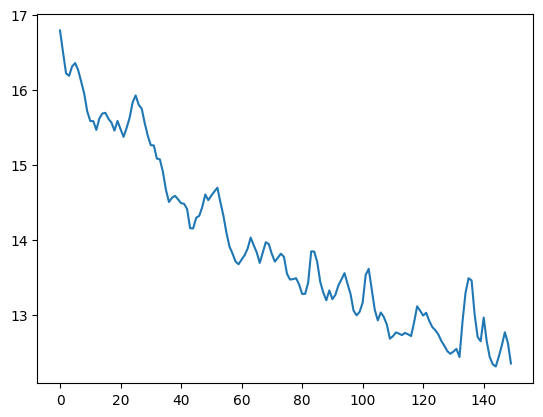

In [76]:
plt.plot(fit_history)

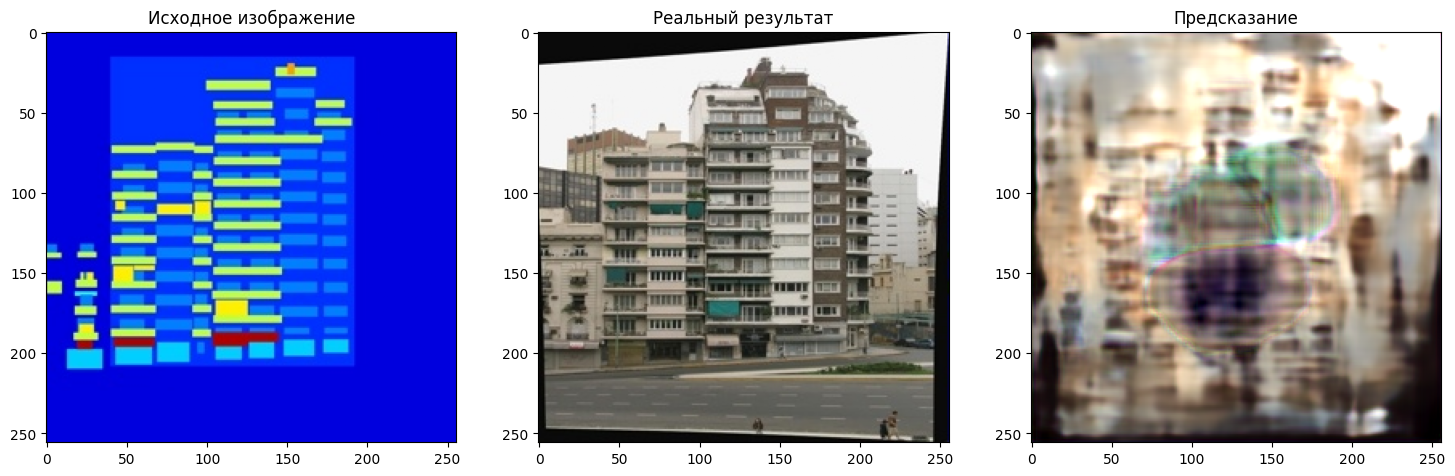

In [77]:
get_predict(G, '/kaggle/input/pix2pix-dataset/facades/facades/val', 0, reverse=True)

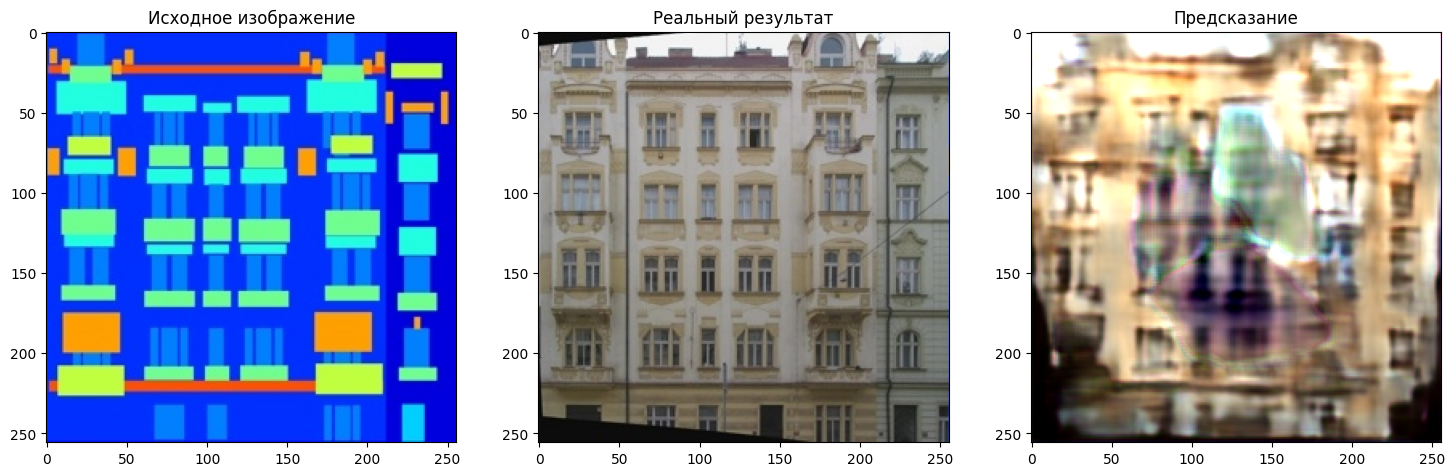

In [78]:
get_predict(G, '/kaggle/input/pix2pix-dataset/facades/facades/val', 10, reverse=True)

### 3.3 Maps

In [94]:
torch.cuda.empty_cache()

In [105]:
G = smp.Unet(classes=3)
D = Discriminator(6)

In [106]:
G = nn.DataParallel(G).to(device)
D = nn.DataParallel(D).to(device)

In [107]:
bce_criterion = nn.BCEWithLogitsLoss()
l1_criterion = nn.L1Loss()

optimizer = torch.optim.Adam(list(G.parameters()) + list(D.parameters()), lr=1e-4)

In [108]:
fit_history = []

G.train()
D.train()

for epoch in tqdm(range(epoch_number)):
    loss_values = []
    for x_batch, y_batch in maps_dataloader:
        
        x_batch = nn.functional.pad(x_batch, (4, 4, 4, 4), 'constant', 0)
        y_batch = nn.functional.pad(y_batch, (4, 4, 4, 4), 'constant', 0)

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        fake = G(x_batch)
        fake_logits = D(fake, x_batch)
        real_logits = D(y_batch, x_batch)

        bce_loss = bce_criterion(fake_logits, torch.ones_like(fake_logits))
        l1_loss = l1_criterion(fake, y_batch)

        G_loss = bce_loss + 200 * l1_loss

        fake_loss = bce_criterion(fake_logits, torch.zeros_like(fake_logits))
        real_loss = bce_criterion(real_logits, torch.ones_like(real_logits))

        disc_loss = (real_loss + fake_loss) / 2

        loss = G_loss + disc_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        x_batch = x_batch.to('cpu')
        y_batch = y_batch.to('cpu')

        del x_batch
        del y_batch

        loss_values.append(loss.item())

    mean_loss = np.mean(loss_values)
    fit_history.append(mean_loss)
    print(f'Эпоха {epoch + 1}, среднее значение функции потерь: {mean_loss}\n')

  5%|▌         | 1/20 [02:05<39:49, 125.78s/it]

Эпоха 1, среднее значение функции потерь: 30.944343636505796



 10%|█         | 2/20 [04:05<36:40, 122.25s/it]

Эпоха 2, среднее значение функции потерь: 22.168448058358074



 15%|█▌        | 3/20 [06:05<34:17, 121.05s/it]

Эпоха 3, среднее значение функции потерь: 21.086254064184036



 20%|██        | 4/20 [08:05<32:09, 120.62s/it]

Эпоха 4, среднее значение функции потерь: 20.32849515093504



 25%|██▌       | 5/20 [10:04<30:04, 120.30s/it]

Эпоха 5, среднее значение функции потерь: 19.749704743823866



 30%|███       | 6/20 [12:05<28:03, 120.25s/it]

Эпоха 6, среднее значение функции потерь: 19.29483191636357



 35%|███▌      | 7/20 [14:04<26:01, 120.12s/it]

Эпоха 7, среднее значение функции потерь: 18.939894000979237



 40%|████      | 8/20 [16:04<23:59, 119.99s/it]

Эпоха 8, среднее значение функции потерь: 18.677198959963164



 45%|████▌     | 9/20 [18:05<22:03, 120.34s/it]

Эпоха 9, среднее значение функции потерь: 18.428485167287562



 50%|█████     | 10/20 [20:05<20:02, 120.25s/it]

Эпоха 10, среднее значение функции потерь: 18.11346101412808



 55%|█████▌    | 11/20 [22:05<18:00, 120.10s/it]

Эпоха 11, среднее значение функции потерь: 17.88724980737171



 60%|██████    | 12/20 [24:05<16:00, 120.12s/it]

Эпоха 12, среднее значение функции потерь: 18.220216131558384



 65%|██████▌   | 13/20 [26:05<14:01, 120.17s/it]

Эпоха 13, среднее значение функции потерь: 17.6062946041135



 70%|███████   | 14/20 [28:05<12:00, 120.09s/it]

Эпоха 14, среднее значение функции потерь: 17.34575689274029



 75%|███████▌  | 15/20 [30:05<09:59, 119.95s/it]

Эпоха 15, среднее значение функции потерь: 17.288955570137414



 80%|████████  | 16/20 [32:05<07:59, 119.88s/it]

Эпоха 16, среднее значение функции потерь: 17.129063731562482



 85%|████████▌ | 17/20 [34:04<05:59, 119.79s/it]

Эпоха 17, среднее значение функции потерь: 16.91935304655646



 90%|█████████ | 18/20 [36:04<03:59, 119.79s/it]

Эпоха 18, среднее значение функции потерь: 16.741004386957545



 95%|█████████▌| 19/20 [38:04<01:59, 119.79s/it]

Эпоха 19, среднее значение функции потерь: 16.593651186810792



100%|██████████| 20/20 [40:04<00:00, 120.23s/it]

Эпоха 20, среднее значение функции потерь: 16.406790308708693



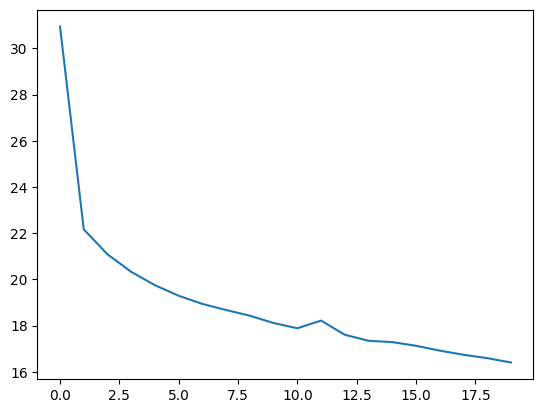

In [109]:
plt.plot(fit_history)

In [116]:
def get_predict(model: nn.Module, val_base_path: str, n: int = 0, reverse=False) -> None:
    val_image_path = get_train_directory_list(val_base_path)[n]
    
    image = read_image(val_image_path).to(torch.float32)

    split = image.size()[2] // 2
    
    x = image[:, :, :split] / 255.
    y = image[:, :, split:] / 255.
    
    if reverse:
        x = image[:, :, split:] / 255.
        y = image[:, :, :split] / 255.
        
    x = nn.functional.pad(x, (4, 4, 4, 4), 'constant', 0)

    predict = model(x.unsqueeze(0))[0]
    
    fig, ax = plt.subplots(1, 3, figsize=(18, 9))
    
    ax[0].set_title('Исходное изображение')
    ax[0].imshow(x.numpy().transpose(1, 2, 0))
    
    ax[1].set_title('Реальный результат')
    ax[1].imshow(y.numpy().transpose(1, 2, 0))
    
    ax[2].set_title('Предсказание')
    ax[2].imshow(predict.cpu().detach().numpy().transpose(1, 2, 0))

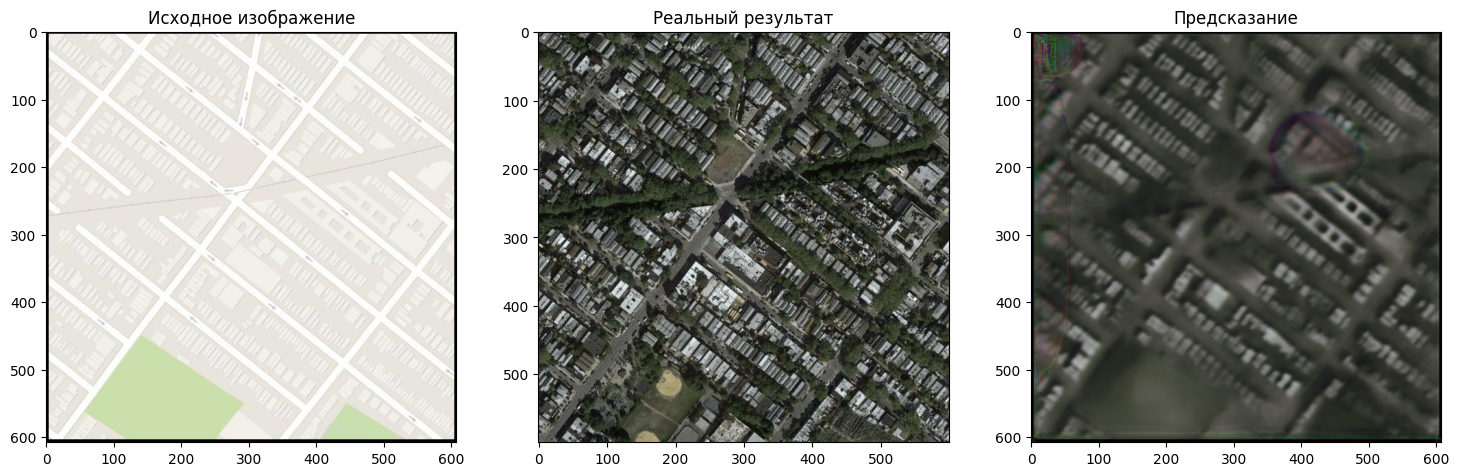

In [117]:
get_predict(G, '/kaggle/input/pix2pix-dataset/maps/maps/val', 0, reverse=True)

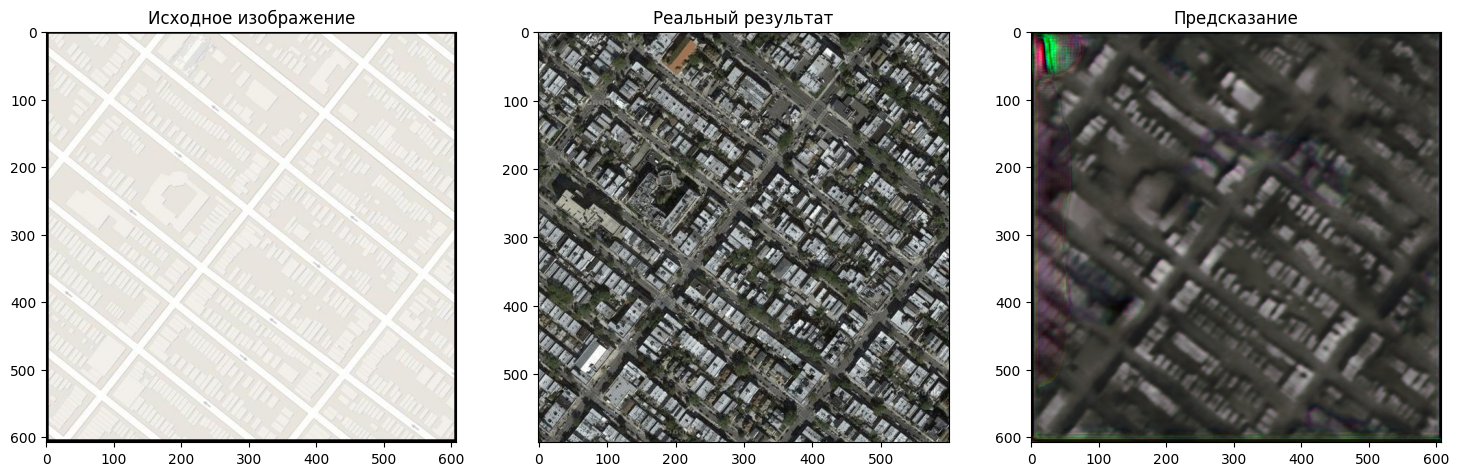

In [118]:
get_predict(G, '/kaggle/input/pix2pix-dataset/maps/maps/val', 10, reverse=True)